In [1]:
#building BGRS version 0

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from itertools import chain, combinations

# BGRS old version

In [3]:
def GRS_score_old(Y: np.ndarray, X: np.ndarray) -> float:
    """
    Calculate the GRS score described in BarillasShanken2018 eq. 3 or, the original paper, Gibbons et al. (1989) or Cochrane2005
    Note that Gibbons et al. (1989) have an additional multiplicative constant that vanish asymptotically and thus is not appearing here.

    Parameters:
        Y (np.ndarray): Dependent variable matrix of dimensions T x N.
        X (np.ndarray): Independent variable matrix of dimensions T x K.

    
    Returns:
        float: GRS score of linear regression Y on X. It is NOT the p-value, it requires additional processing
    """
    
    T, N = Y.shape
    K = X.shape[1]

    # Add a constant term to the independent variable matrix X
    X_with_intercept = sm.add_constant(X)

    # Initialize arrays to store parameters
    alpha = np.zeros((1, N))
    beta = np.zeros((K, N))
    residuals = np.zeros((T, N))

    # Loop over each target variable
    for n in range(N):
        # Fit OLS regression model for each target variable
        model = sm.OLS(Y[:, n], X_with_intercept)
        results = model.fit()

        # Extract parameters
        alpha[0, n] = results.params[0]
        beta[:, n] = results.params[1:]
        residuals[:, n] = results.resid



    #create Epsilon ~ (N,N) and its inverse
    Epsilon=np.cov(residuals,rowvar=False) 
    inverse_Epsilon=np.linalg.inv(Epsilon)

    #average of factors X
    mu=np.mean(X,axis=0)

    #covariance of factors X and its inverse
    Omega=np.cov(X,rowvar=False) 

    if K==1:
        inverse_Omega=1/Omega

    else:
        inverse_Omega=np.linalg.inv(Omega)
   
    
    GRS=((T-N-K)/N)*np.dot(np.dot(alpha, inverse_Epsilon), alpha.T)/(1+np.dot(np.dot(mu.T, inverse_Omega), mu))
    GRS=float(GRS[0,0]) #convert to float

    
    return GRS

In [4]:
def ML_unrestricted_old(Y: np.ndarray, X: np.ndarray, Sh_max_2: float ) -> float:
    """
    Calculate the marginal likelihoods of the unrestricted linear regression model in BarillasShanken2018 eq. 9:
    Yt = α + Xt β + εt (non restricted)

    α ~ 1 x N
    β ~ K x N
    ε ~ T x N

    Parameters:
        Y (np.ndarray): Dependent variable matrix of dimensions T x N.
        X (np.ndarray): Independent variable matrix of dimensions T x K.
        Sh_max_2 (float): square of the maximum expected sharp ratio

    Returns:
        float: Marginal likelihood of the unrestricted linear regression model.
    """
    print("unrestricted")
    print(Y.shape)
    print(X.shape)
    
    T, N = Y.shape
    K = X.shape[1]
   

    # Add a constant term to the independent variable matrix X
    X_with_intercept = sm.add_constant(X)

    # Initialize arrays to store parameters
    alpha = np.zeros((1, N))
    beta = np.zeros((K, N))
    residuals = np.zeros((T, N))

    # Loop over each target variable
    for n in range(N):
        # Fit OLS regression model for each target variable
        model = sm.OLS(Y[:, n], X_with_intercept)
        results = model.fit()

        # Extract parameters
        alpha[0, n] = results.params[0]
        beta[:, n] = results.params[1:]
        residuals[:, n] = results.resid

    #compute the relevant term for Marginal likelihood
    XX=np.linalg.det(X.T @ X)

    print(np.cov(residuals, rowvar=False).shape)
    S=np.linalg.det(np.cov(residuals, rowvar=False))

    #construction of W
    W=GRS_score(Y,X)*(N*T)/(T-N-K)

    #construction of sharp ratio of X
    
    #average of factors X
    mu=np.mean(X,axis=0)

    #covariance of factors X and its inverse
    Omega=np.cov(X,rowvar=False) 
    if K==1:
        inverse_Omega=1/Omega

    else:
        inverse_Omega=np.linalg.inv(Omega)

    #it is im portant to understand that mu * Omega**-1 * mu = Sh(X)**2 which appears clear by comparing 
    #the GRS score in BarillasShanken2018 eq.3 with the original paper, Gibbons et al. (1989)
    Sharp_ratio_X_2=np.dot(np.dot(mu.T, inverse_Omega), mu)

    #construction of k and a:
    k=(Sh_max_2-Sharp_ratio_X_2)/N
    a=(1+Sharp_ratio_X_2)/T

    #construction of Q
    Q=((1+(a/(a+k))*(W/T))**(-(T-K)/2)) * ((1+k/a)**(-N/2))

    
    ML_u=(XX**(-N/2)) * (S**(-(T-K)/2)) * Q
    return ML_u

In [5]:
def ML_restricted_old(Y: np.ndarray, X: np.ndarray) -> float:
    """
    Calculate the marginal likelihoods of the restricted linear regression model in BarillasShanken2018 eq. 10:
    Yt =  Xt β + εt (non restricted)

    β ~ K x N
    ε ~ T x N

    Parameters:
        Y (np.ndarray): Dependent variable matrix of dimensions T x N.
        X (np.ndarray): Independent variable matrix of dimensions T x K.

    Returns:
        float: Marginal likelihood of the unrestricted linear regression model.
    """
    print(Y.shape)
    print(X.shape)
    T, N = Y.shape
    K = X.shape[1]

   

    # Initialize arrays to store parameters
    beta = np.zeros((K, N))
    residuals = np.zeros((T, N))

    # Loop over each target variable
    for n in range(N):
        # Fit OLS regression model for each target variable
        model = sm.OLS(Y[:, n], X)
        results = model.fit()

        # Extract parameters
        beta[:, n] = results.params
        residuals[:, n] = results.resid

    #compute the relevant term for Marginal likelihood
    XX=np.linalg.det(X.T @ X)

    print(np.cov(residuals, rowvar=False).shape)
    SR=np.linalg.det(np.cov(residuals, rowvar=False))

    
    ML_r=(XX**(-N/2)) * (SR**(-(T-K)/2)) 
    return ML_r

In [6]:
def ML_old(F: np.ndarray, F_excluded: np.ndarray, Mkt: np.ndarray, R: np.ndarray, Sh_max_2: float ) -> float:
    """
    Calculate the marginal likelihoods using the restricted and unrestricted marginal likelihoods previously defined
    as defined in eq.19 in BarillasShanken2018. The last term is omitted since it will cancel out in the following (eq.17).
    Note that the canceling is mentionned in BarillasShanken2018 and we follow their path. 

    
    Parameters:
        F (np.ndarray)         : Included factors in the model to be tested, T x (K-K_excluded)
        F_excluded (np.ndarray): Excluded factors in the model to be tested, T x K_excluded
        Mkt (np.ndarray)       : Market excess return Mkt-Rf, T x 1
        R    (np.ndarray)      : Returns of the N portfolios, T x N
        Sh_max_2 (float)       : square of the maximum expected sharp ratio

    Returns:
        float: Marginal likelihood
    """

    concatenated_F_Mkt = np.concatenate((F, Mkt), axis=1)
    
    ML=ML_unrestricted(F,Mkt,Sh_max_2)*ML_restricted(F_excluded,concatenated_F_Mkt)

    return ML
    

In [7]:
def all_possibilities_BGRS_old(l: list) -> list:
    """
    Compute all combinations of factors possible using the inputed list of name of factors.
    Note that the original complete list is not returned in this version only the sublists are returned.

    
    Parameters:
        l(List[str]): list of name of factors

    Returns:
        List[List[str]]: list of all sublist of name of factors
    """

    #note: if you want to code something nicer and more commented than 
    #that you can, however, 
    #it's pretty easy to convinve yourself that the function is 
    #correct by trying a few list of factors
    
    def possibilities_BGRS(list_fn,factor_name_):
   
        for f in factor_name_:
            factor_name__=factor_name_.copy()
            factor_name__.remove(f)
            if len(factor_name__)>0:
                list_fn.append(factor_name__)
                possibilities_BGRS(list_fn,factor_name__)
    
    original_list=[l]
    possibilities_BGRS(original_list,l)
    
    seen = set()
    unique_list = []
    
    for sublist in original_list:
        sublist_tuple = tuple(sublist)
        if sublist_tuple not in seen:
            unique_list.append(sublist)
            seen.add(sublist_tuple)
    
    return unique_list[1:]

In [8]:
def BGRS_old(return_portfolio: pd.DataFrame, factors: pd.DataFrame, prior_mkt: float, list_of_models: list = None) -> pd.DataFrame:
    """
    Perform the BGRS analysis using the provided return portfolio, factors, and 
    prior parameters 

    Parameters:
        return_portfolio (pd.DataFrame): DataFrame containing return of N portfolios, T x N
        factors (pd.DataFrame): DataFrame containing factors. Note that 1 column should absolutely be named "Mkt-RF", T x K
        prior_mkt (float): Prior parameters used later in the computation of the maximum expected sharp ratio. 
        list_of_model (list): list of model to be analyzed, if None is provided compute all possible models

    Note that a "model" is a list of factors name (strings) which must correspond to columns in factors (inputed dataframe)
    Note that the index of return_portfolio and factors should match and be time ordered.

    Returns:
        dataframe containing the marginal likelihood of all models of interest
    """

    
    #If None is provided compute all possible models

    all_factors_name=list(factors.drop(columns=["Mkt-RF"]).columns)
   
    if list_of_models==None:
        list_of_models=all_possibilities_BGRS(all_factors_name)

    #initialize dictionnary to store marginal likelihoods
    dict_results={"index":list(return_portfolio.index)}
    
    for model in list_of_models:
        name_model=" ".join(model)

        names_F_included=model
        names_F_excluded= [string for string in all_factors_name if string not in model]

        #extract the relevant data from the dataframes
        F_included=factors[names_F_included].copy(deep=True)
        F_excluded=factors[names_F_excluded].copy(deep=True)

        Market=factors["Mkt-RF"]

        Sh_mkt=Market.mean()/Market.std()

        Sh_max=prior_mkt*Sh_mkt


        print("Shape of F_included array:", F_included.values.shape)
        print("Shape of F_excluded array:", F_excluded.values.shape)
        print("Shape of Market array:", Market.values.reshape(-1,1).shape)
        print("Shape of return_portfolio array:", return_portfolio.values.shape)
        
        marginal_likelihood=ML(F_included.values,
                                      F_excluded.values,
                                      Market.values.reshape(-1,1),
                                      return_portfolio.values,
                                      Sh_max**2)

        
                


        dict_result[name_model]=marginal_likelihood
        
    return pd.DataFrame(dict_result).set_index('index', inplace=True)
    
    #if you want the probabilities instead:

    #    dataframe_results=pd.DataFrame(dict_result).set_index('index', inplace=True)
    #    return dataframe_results.div(dataframe_results.sum(axis=1), axis=0)
    
    
    

# BGRS

In [54]:
def GRS_score(Y: np.ndarray, X: np.ndarray) -> float:
    """
    Calculate the GRS score described in BarillasShanken2018 eq. 3 or, the original paper, Gibbons et al. (1989) or Cochrane2005
    Note that Gibbons et al. (1989) have an additional multiplicative constant that vanish asymptotically and thus is not appearing here.

    Parameters:
        Y (np.ndarray): Dependent variable matrix of dimensions T x N.
        X (np.ndarray): Independent variable matrix of dimensions T x K.

    
    Returns:
        float: GRS score of linear regression Y on X. It is NOT the p-value, it requires additional processing
    """
    
    T, N = Y.shape
    K = X.shape[1]

    # Add a constant term to the independent variable matrix X
    X_with_intercept = sm.add_constant(X)

    # Initialize arrays to store parameters
    alpha = np.zeros((1, N))
    beta = np.zeros((K, N))
    residuals = np.zeros((T, N))

    # Loop over each target variable
    for n in range(N):
        # Fit OLS regression model for each target variable
        model = sm.OLS(Y[:, n], X_with_intercept)
        results = model.fit()

        # Extract parameters
        alpha[0, n] = results.params[0]
        beta[:, n] = results.params[1:]
        residuals[:, n] = results.resid


    #create Epsilon ~ (N,N) and its inverse
    Epsilon=np.cov(residuals,rowvar=False,bias=True) 
    inverse_Epsilon=np.linalg.inv(Epsilon)

    #average of factors X
    mu=np.mean(X,axis=0)


    #covariance of factors X and its inverse
    Omega=np.cov(X,rowvar=False,bias=True) 

    if K==1:
        inverse_Omega=1/Omega

    else:
        inverse_Omega=np.linalg.inv(Omega)

  
    
    GRS=((T-N-K)/N)*np.dot(np.dot(alpha, inverse_Epsilon), alpha.T)/(1+np.dot(np.dot(mu.T, inverse_Omega), mu))
    GRS=float(GRS[0,0]) #convert to float

    Wald=T * np.dot(np.dot(alpha, inverse_Epsilon), alpha.T)/(1+np.dot(np.dot(mu.T, inverse_Omega), mu))
    Wald=float(Wald[0,0])
    
    
    return GRS

In [58]:
def ML_unrestricted(F: np.ndarray, F_excluded: np.ndarray, Mkt: np.ndarray, return_portfolio: np.ndarray, prior_multiple: float ) -> float:
    """
    Calculate the marginal likelihoods of the unrestricted linear regression model in BarillasShanken2018 eq. 9:
    Yt = α + Xt β + εt (non restricted)

    Yt (T x (N+K_excluded)) ~ the N portfolios (T x N) + the excluded factors (T x K_excluded) 

    Xt (T x (K-K_excluded+1)) ~ the included factors (T x (K-K_excluded)) + the market (T x 1)


    for notation purposes: 
    (N+K_excluded)=M
    (K-K_excluded)=K_included
    
    α ~ 1 x M
    β ~ (K_included+1) x M
    ε ~ T x M

    comparison with notation in BarillasShanken2018 eq. 9:
    
    |FF| = |XX|
    with XX ~ ((K_included+1) x (K_included+1))

    |S| = |εε|
    with εε ~ (M x M)

    Q is constructed with the GRS score based on the regression Yt = α + Xt β + εt


    Parameters:
        F (np.ndarray)                 : Included factors in the model to be tested, T x K_included
        F_excluded (np.ndarray)        : Excluded factors in the model to be tested, T x K_excluded
        Mkt (np.ndarray)               : Market excess return Mkt-Rf, T x 1
        return_portfolio (np.ndarray)  : Returns of the N portfolios, T x N
        prior_multiple (float)         : scalar use to define k from Sh_mkt (BarillasShanken2018 eq. 7)

    Returns:
        float: Marginal log-likelihood of the unrestricted linear regression model.
    """

    Y=np.concatenate((return_portfolio, F_excluded), axis=1)

    if F.shape[1]==0: #special case where only the mkt is an exogenous variable
        X=Mkt
    else:
        X=np.concatenate((F,Mkt),axis=1)

    
    T, M = Y.shape
    K_spec = X.shape[1] #K_spec=K_included+1
   

    # Add a constant term to the independent variable matrix X
    X_with_intercept = sm.add_constant(X)

    # Initialize arrays to store parameters
    alpha = np.zeros((1, M))
    beta = np.zeros((K_spec, M))
    residuals = np.zeros((T, M))

    # Loop over each target variable
    for m in range(M):
        # Fit OLS regression model for each target variable
        model = sm.OLS(Y[:, m], X_with_intercept)
        results = model.fit()

        # Extract parameters
        alpha[0, m] = results.params[0]
        beta[:, m] = results.params[1:]
        residuals[:, m] = results.resid

    #compute the relevant term for Marginal likelihood
    
    lnXX=np.log(np.linalg.det(X.T @ X))

    lnS=np.log(np.linalg.det(residuals.T @ residuals))

    #construction of W
    W=GRS_score(Y,X)*(M*T)/(T-M-K_spec)

    #construction of sharp ratio of X
    
    #average of factors X
    mu=np.mean(X,axis=0)

    #covariance of factors X and its inverse
    Omega=np.cov(X,rowvar=False,bias=True) 
    if K_spec==1:
        inverse_Omega=1/Omega

    else:
        inverse_Omega=np.linalg.inv(Omega)

    #it is im portant to understand that mu * Omega**-1 * mu = Sh(X)**2 which appears clear by comparing 
    #the GRS score in BarillasShanken2018 eq.3 with the original paper, Gibbons et al. (1989)
    Sharp_ratio_X_2=np.dot(np.dot(mu.T, inverse_Omega), mu)

    #construction of k and a:
    k=(prior_multiple**2-1)*Sharp_ratio_X_2/M
    a=(1+Sharp_ratio_X_2)/T

    #construction of Q
    lnQ=np.log(1+(a/(a+k))*(W/T))*(-(T-K_spec)/2) + np.log(1+k/a)*(-M/2)

    
    lnML_u=lnXX*(-M/2)+lnS*(-(T-K_spec)/2)+lnQ
    return lnML_u

In [59]:
def ML_restricted(F: np.ndarray, F_excluded: np.ndarray, Mkt: np.ndarray, return_portfolio: np.ndarray) -> float:
    """
    Calculate the marginal likelihoods of the restricted linear regression model in BarillasShanken2018 eq. 9:
    Yt = Xt β + εt (restricted, α=0)

    Yt (T x (N+K_excluded)) ~ the N portfolios (T x N) + the excluded factors (T x K_excluded) 

    Xt (T x (K-K_excluded+1)) ~ the included factors (T x (K-K_excluded)) + the market (T x 1)


    for notation purposes: 
    (N+K_excluded)=M
    (K-K_excluded)=K_included
    
   
    β ~ (K_included+1) x M
    ε ~ T x M

    comparison with notation in BarillasShanken2018 eq. 9:
    
    |FF| = |XX|
    with XX ~ ((K_included+1) x (K_included+1))

    |SR| = |εε|
    with εε ~ (M x M)

    


    Parameters:
        F (np.ndarray)                 : Included factors in the model to be tested, T x K_included
        F_excluded (np.ndarray)        : Excluded factors in the model to be tested, T x K_excluded
        Mkt (np.ndarray)               : Market excess return Mkt-Rf, T x 1
        return_portfolio (np.ndarray)  : Returns of the N portfolios, T x N
       
    Returns:
        float: Marginal log-likelihood of the restricted linear regression model.
    """
    
    Y=np.concatenate((return_portfolio, F_excluded), axis=1)

    if F.shape[1]==0: #special case where only the mkt is an exogenous variable
        X=Mkt
    else:
        X=np.concatenate((F,Mkt),axis=1)
   

    
    T, M = Y.shape
    K_spec = X.shape[1] #K_spec=K_included+1
   

    # Initialize arrays to store parameters
    beta = np.zeros((K_spec, M))
    residuals = np.zeros((T, M))

    # Loop over each target variable
    for m in range(M):
        # Fit OLS regression model for each target variable
        model = sm.OLS(Y[:, m], X)
        results = model.fit()

        # Extract parameters
        beta[:, m] = results.params
        residuals[:, m] = results.resid

    #compute the relevant term for Marginal likelihood
    lnXX=np.log(np.linalg.det(X.T @ X))

    lnSR=np.log(np.linalg.det(residuals.T @ residuals))


    lnML_r=lnXX*(-M/2)+lnSR*(-(T-K_spec)/2)
    return lnML_r

In [12]:
def ML(F: np.ndarray, F_excluded: np.ndarray, Mkt: np.ndarray, return_portfolio: np.ndarray, prior_multiple: float ) -> float:
    """
    Calculate the marginal likelihoods as defined in eq.19 in BarillasShanken2018 using the restricted and unrestricted marginal 
    likelihoods previously defined. The last term is omitted since it will cancel out in the following (eq.17).
    Note that the canceling is mentionned in BarillasShanken2018 and we follow their path. 

    
    Parameters:
        F (np.ndarray)         : Included factors in the model to be tested, T x (K-K_excluded)
        F_excluded (np.ndarray): Excluded factors in the model to be tested, T x K_excluded
        Mkt (np.ndarray)       : Market excess return Mkt-Rf, T x 1
        R    (np.ndarray)      : Returns of the N portfolios, T x N
        prior_multiple (float) : square of the maximum expected sharp ratio

    Returns:
        float: Marginal log-likelihood
    """

    lnML=ML_unrestricted(F, F_excluded, Mkt, return_portfolio, prior_multiple)+ML_restricted(F, F_excluded, Mkt, return_portfolio)

    return lnML

In [13]:
def all_possibilities_BGRS(l: list) -> list:
    """
    Compute all combinations of factors possible using the inputed list of name of factors.
    Note that the original complete list is not returned, only the sublists are returned.

    Parameters:
        l(List[str]): list of name of factors

    Returns:
        List[List[str]]: list of all sublist of name of factors
    """

    def all_subsets(values):
        subsets = []
        for r in range(len(values)):
            #if r>0:
                subsets.extend(list(combinations(values, r)))
        return subsets

    complete_set=set(l)

    list_subset=all_subsets(complete_set)

    return list_subset

In [14]:
def from_marginal_likelihood_to_probability(df_results: pd.DataFrame) -> pd.DataFrame:
    """
    last step of the BGRS, the function transforms the marginal log-likelihoods to posterior probabilities. Since the involved numbers
    are large, the function is careful when taking the exponential of such combination of numbers. 

    Following the steps of BarillasShanken2018 (eq.17), we compute the posterior probabilities assuming uniform prior model probabilities.

    P(Mi|D)=MLi/sum{j}(MLj)=1/sum{j}(MLj/MLi)

    and focusing on the sum in the denominator:

    sum{j}(MLj/MLi)=sum{j}(exp(lnMLj-lnMLi))

    Parameters:
        df_results (pd.DataFrame) : DataFrame containing marginal log-likelihoods for given combinations of factors

    Returns:
        dataframe containing the posterior probabilities, the format is the same as the one inputed
    """

    
    # Define a function to compute P_i for each value
    def compute_P_i(value, row):
        exp_sum = np.sum(np.exp(row.values - value))
        return 1 / exp_sum
    
    # Apply the function to each value in the DataFrame
    df_proba = df_results.apply(lambda row: row.apply(lambda x: compute_P_i(x, row)), axis=1)

    

    return df_proba
    
    

In [15]:
def BGRS(return_portfolio: pd.DataFrame, factors: pd.DataFrame, prior_multiple: float, list_of_models: list = None) -> pd.DataFrame:
    """
    Perform the BGRS analysis (absolute version, thus including portfolio as endogenous variables) using the provided return portfolio, factors, and 
    prior parameter

    Parameters:
        return_portfolio (pd.DataFrame) : DataFrame containing return of N portfolios, T x N
        factors (pd.DataFrame)          : DataFrame containing factors. Note that one column should absolutely be named "Mkt-RF", T x K
        prior_multiple (float)          : Prior parameters used later in the computation of the maximum expected sharp ratio. 
        list_of_model (list)            : list of model to be analyzed, if None is provided compute all possible models

    Note that a "model" is a list of factors name (strings) which must correspond to columns in factors (inputed dataframe)
    /!\ Note that the index of return_portfolio and factors should match and be time ordered.
    
    Returns:
        dataframe containing the marginal log-likelihood of all models of interest
    """
    N=return_portfolio.shape[1]
    K=factors.shape[1]
    
    #If None is provided compute all possible models

    all_factors_name=list(factors.drop(columns=["Mkt-RF"]).columns)
   
    if list_of_models==None:
        list_of_models=all_possibilities_BGRS(all_factors_name)

    #initialize dictionnary to store marginal likelihoods
    dict_results={"index":list(return_portfolio.index)}
    
    for model in list_of_models:
       
        name_model=" ".join(list(model))

        names_F_included=list(model)
        names_F_excluded= [string for string in all_factors_name if string not in list(model)]

        
        #extract the relevant data from the dataframes
        F_included=factors[names_F_included].copy(deep=True)
        F_excluded=factors[names_F_excluded].copy(deep=True)

        Market=factors["Mkt-RF"]

        
        log_marginal_likelihoods=[]
        for index_date,date in enumerate(dict_results["index"]):
            if index_date<=N+K:
                log_marginal_likelihoods.append(np.nan)
            else:   
                #to be removed
                #print("------------------------------------------------")
                #print(F_included[:index_date].values.shape)
                #print(F_excluded[:index_date].values.shape)
                #print(Market[:index_date].values.reshape(-1,1).shape)
                #print(return_portfolio[:index_date].values.shape)
                
                
                log_marginal_likelihoods.append(ML(F_included[:index_date].values,
                                              F_excluded[:index_date].values,
                                              Market[:index_date].values.reshape(-1,1),
                                              return_portfolio[:index_date].values,
                                              prior_multiple))

        
                


        dict_results[name_model]=log_marginal_likelihoods
        
    #return from_marginal_likelihood_to_probability(pd.DataFrame(dict_results).set_index('index'))
    return pd.DataFrame(dict_results).set_index('index')
    
    
    
    

# TEST

In [62]:
len(all_possibilities_BGRS(["a","b","c","d","e","f"]))

63

In [63]:
np.concatenate((np.random.rand(200, 20), np.random.rand(200, 4)), axis=1).shape

(200, 24)

In [64]:
GRS_score(np.random.rand(200, 20),np.random.rand(200, 4))

43.86518268737758

In [65]:
df=pd.read_csv('../../../test_BGRS.csv')
df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
df.set_index('date', inplace=True)

In [66]:
portfolio_list = [
    'portfolio_0', 'portfolio_1', 'portfolio_2', 'portfolio_3', 'portfolio_4',
    'portfolio_5', 'portfolio_6', 'portfolio_7', 'portfolio_8', 'portfolio_9',
    'portfolio_10', 'portfolio_11', 'portfolio_12', 'portfolio_13', 'portfolio_14',
    'portfolio_15', 'portfolio_16', 'portfolio_17', 'portfolio_18', 'portfolio_19'
]

factor_list = ['Mkt-RF', 'HML', 'SMB', 'UMD', 'CyberFactor']


return_portfolio=df[portfolio_list].copy(deep=True)
factors=df[factor_list].copy(deep=True)

df_results=BGRS(return_portfolio,factors,1.25)

<Axes: xlabel='index'>

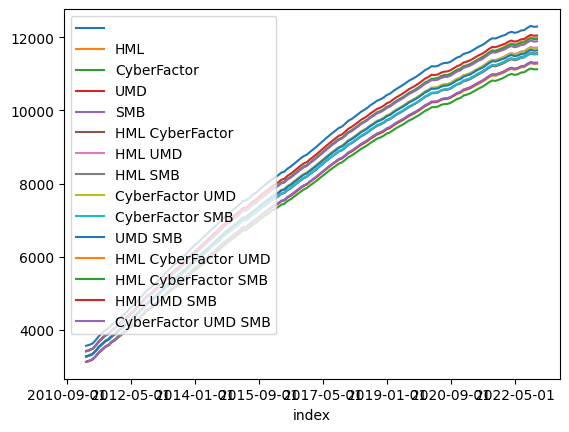

In [68]:
df_results.plot()

In [21]:
from_marginal_likelihood_to_probability(df_results)

C:\Users\natha\AppData\Local\Temp\ipykernel_10688\2716116652.py:24: RuntimeWarning: overflow encountered in exp
  exp_sum = np.sum(np.exp(row.values - value))


,,HML,CyberFactor,UMD,SMB,HML CyberFactor,HML UMD,HML SMB,CyberFactor UMD,CyberFactor SMB,UMD SMB,HML CyberFactor UMD,HML CyberFactor SMB,HML UMD SMB,CyberFactor UMD SMB
index,,,,,,,,,,,,,,,
2009-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,1.0,5.680282e-136,1.715050e-146,2.959091e-106,2.476677e-173,0.0,2.882207e-249,0.0,1.155127e-255,0.0,7.268449e-281,0.0,0.0,0.0,0.0
2022-09-01,1.0,1.191714e-136,7.580160e-147,9.791965e-107,5.716421e-174,0.0,1.806515e-250,0.0,1.778480e-256,0.0,5.736771e-282,0.0,0.0,0.0,0.0
2022-10-01,1.0,2.900047e-137,1.986196e-147,3.434122e-107,7.732890e-175,0.0,1.374617e-251,0.0,1.564238e-257,0.0,2.644311e-283,0.0,0.0,0.0,0.0


In [48]:
grs=GRS_score(return_portfolio.values,factors.values)

omega
[[ 2.10865811e-03  3.13920399e-04  4.56131733e-04 -7.83298355e-04
   7.09783967e-05]
 [ 3.13920399e-04  1.15778940e-03  2.57639870e-04 -5.62577195e-04
  -7.25965525e-04]
 [ 4.56131733e-04  2.57639870e-04  6.88141814e-04 -3.44313717e-04
  -1.18976034e-04]
 [-7.83298355e-04 -5.62577195e-04 -3.44313717e-04  2.08704270e-03
   2.38746535e-04]
 [ 7.09783967e-05 -7.25965525e-04 -1.18976034e-04  2.38746535e-04
   9.46509014e-04]]
epsilon
[[ 2.34637010e-04 -1.44640226e-05  5.25016087e-07  1.18809996e-05
   1.82364163e-07  3.07503552e-05  7.05432071e-05  1.48042093e-05
  -2.33779220e-06  1.13576079e-05  3.35892864e-05 -1.47853415e-05
   4.14064557e-05 -3.24766843e-05 -5.12452623e-05  1.35480948e-05
   1.89994782e-05  1.45436543e-05  2.31743828e-05  6.87643099e-05]
 [-1.44640226e-05  3.14484493e-04 -8.47536860e-05 -3.99560457e-05
   1.67798543e-05 -1.41732305e-05 -5.13683267e-05 -4.34962616e-06
   1.74502865e-05 -5.38927047e-06 -9.64217177e-06 -6.48891515e-05
   4.25952425e-05  4.98937903e-

In [49]:
grs

1.4164263049408254

In [50]:
from scipy.stats import f

In [51]:
1 - f.cdf(grs, 20, 168-20-5)

0.12364387511356345

In [60]:

F=factors[['HML', 'SMB', 'UMD', 'CyberFactor']]
F_excluded=factors[[]]
Mkt=factors[["Mkt-RF"]]
prior_multiple=1.25

lnMLR=ML_restricted(F, F_excluded, Mkt, return_portfolio)
lnMLU=ML_unrestricted(F, F_excluded, Mkt, return_portfolio, prior_multiple) 

In [61]:
np.exp(lnMLR-lnMLU)

0.5623307916997538